### Challenge cellules polylobulées
Manuel Izquierdo <ma.izquierdo@umontreal.ca>

Indicate here the directory containing the files `Results.csv` and `Composite.tif`:

In [117]:
! cd ~/Desktop/CONTINUUM/PYTHON 

In [118]:
# Main imports
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import imageio

In [120]:
# * Set the maximum distance between nuclei (in pixels) 
MAX_DISTANCE = 70

Number of clusters 61


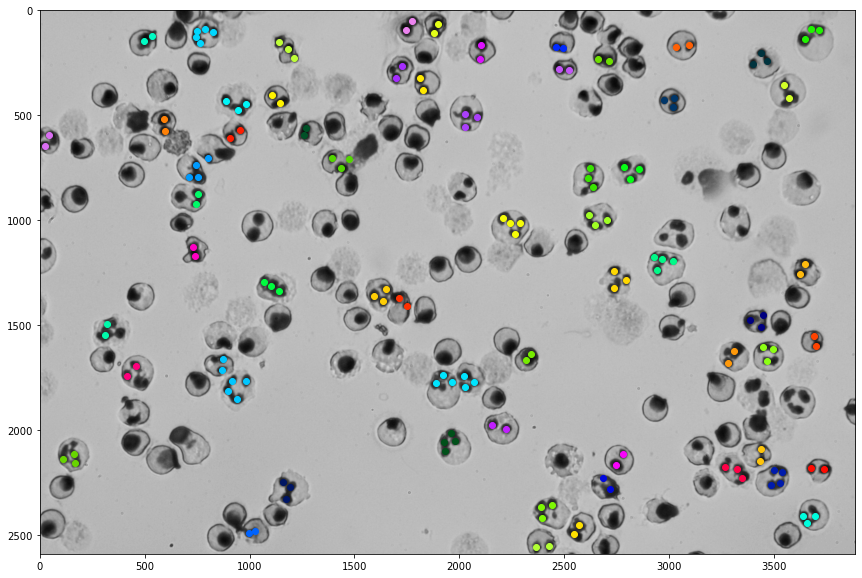

In [130]:
# * Read dataset
data = pd.read_csv('Results.csv')

# * extract coordinates of each nuclei
points = data[['X', 'Y']].to_numpy()

# * Stage 1: Calculate distances
point_pairs_distances = set()
for idx, p1 in enumerate(points):
    # * Euclidean distance between each point `p1` and all the other points 
    # * of the dataset is calculated with np.linalg.norm() (setting a matrix 2-norm)
    dist_p1_others = np.linalg.norm(points - p1, ord=2, axis=1)
    
    # * reorganize the results into a numpy array in the form:
    # * [ [ p1_x, p1_y, pN_x, pN_y, dist], ...]
    q = np.repeat([p1], repeats=len(points), axis=0)
    dist_report = np.column_stack((q, points, dist_p1_others))
    
    # * Filter out invalid distances
    dist_report = dist_report[(dist_report[:,4] > 0)]
    dist_report = dist_report[(dist_report[:,4] <= MAX_DISTANCE)]
    
    # * Valid distances are added to `point_pairs_distances` set in the form:
    # * { {p1_x, p1_y}, {pN_x, pN_y,}, dist}
    if len(dist_report) > 0:
        for d in dist_report:
            # * frozenset() allow to add a set into another set
            point_pairs_distances.add( (frozenset([  (d[0], d[1]), (d[2], d[3])  ]), d[4]) )
 
# * Dump the coordinates of all the filtered points into an array
detected_points = []
for p in point_pairs_distances:
    points = list([_m for _m in list(p) if type(_m) ==  frozenset][0])
    detected_points.append(points[0])
    detected_points.append(points[1])

detected_points = np.array(detected_points)


# * Second stage. Cluster detection

# * Graph Theory is used. The idea is to create a graph where 
# * the nodes correspond to the points detected by the previous
# * stage. The edges describe the distances (< 70 pixes) 
# * connecting each other. 
# * For this, the networkx library is used.

# * Create an empty (undirected) Graph
G = nx.Graph()

# * add points as nodes
for node in detected_points:
    G.add_node(tuple(node))

# * add distances as edges
for ppd in point_pairs_distances:
    pointsAB = list(ppd[0])
    G.add_edge(pointsAB[0], pointsAB[1], distance=ppd[1])

# * Extract the list of connected components of the Graph, which
# * inform us about the clusters.
# * The clustering information is encoded in a dictionary of the form
# * { (point_x, point_x): 'cluster number',  ... }
# * where `cluster number` is a string `c1`, `c2`, ...
cluster_index = {}
for idx, cluster in enumerate(nx.connected_components(G)):
    for item in cluster:
        cluster_index[item] = 'c%s' % idx
        
 


# * Stage 3. Plot clusters

# * Plot background image. 
# * Thanks @Adele for this code! :)
image = imageio.imread('Composite.tif')
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)
ax.imshow(image, cmap='gray')

# * Plot a scatter for each detected cluster 
for cluster in nx.connected_components(G):
    cluster = np.array(list(cluster))
    # * uncomment to plot the graph connection
    #ax.plot(cluster[:,0], cluster[:,1])
    ax.scatter(cluster[:,0], cluster[:,1])
    
# * cosmetic manipulation of color ramp in matplotlib
colormap = plt.cm.gist_ncar 
colorst = [colormap(i) for i in np.linspace(0, 0.9,len(ax.collections))]       
for t,j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])

# * uncomment to plot all the points
# xOri = data[['X']].to_numpy()
# yOri = data[['Y']].to_numpy()
# plt.scatter(xOri, yOri, c='#aaaaaa', marker='+')


# * Stage 4. Add results back into the Pandas dataframe
data['Cell'] = 'isolated'
for coord, cidx in cluster_index.items():
    data.loc[(data['X'] == coord[0]) & (data['Y'] == coord[1]), 'Cell'] = cidx
   

print("Number of clusters", len( [_m for _m in nx.connected_components(G)]))

In [129]:
data

,,Label,Area,Mean,Min,Max,X,Y,XM,YM,...,Feret,IntDen,RawIntDen,FeretX,FeretY,FeretAngle,MinFeret,MinThr,MaxThr,Cell
0,17,C2-Composite.tif,3967,255,255,255,689.557,26.190,689.557,26.190,...,87.727,1011585,1011585,647,0,133.152,67.000,0,0,isole
1,18,C2-Composite.tif,3892,255,255,255,2526.930,29.601,2526.930,29.601,...,99.282,992460,992460,2476,44,26.307,64.000,0,0,isole
2,19,C2-Composite.tif,1253,255,255,255,2890.721,12.112,2890.721,12.112,...,58.694,319515,319515,2860,0,171.180,30.000,0,0,isole
3,20,C2-Composite.tif,1912,255,255,255,3238.619,20.885,3238.619,20.885,...,68.884,487560,487560,3204,10,170.811,37.142,0,0,isole
4,21,C2-Composite.tif,2058,255,255,255,1776.624,51.585,1776.624,51.585,...,67.067,524790,524790,1745,42,159.944,43.821,0,0,c60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,281,C2-Composite.tif,4621,255,255,255,883.648,2525.869,883.648,2525.869,...,100.210,1178355,1178355,862,2579,53.931,79.551,0,0,isole
265,282,C2-Composite.tif,2823,255,255,255,3552.341,2523.306,3552.341,2523.306,...,64.661,719865,719865,3532,2499,129.352,58.585,0,0,isole
266,283,C2-Composite.tif,3206,255,255,255,2690.798,2559.379,2690.798,2559.379,...,77.078,817530,817530,2685,2521,112.906,56.501,0,0,isole
267,284,C2-Composite.tif,1917,255,255,255,2426.191,2552.180,2426.191,2552.180,...,62.394,488835,488835,2419,2585,83.558,43.380,0,0,c31
